In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import PIL
import read_datasets as rd
import constants as CONST
from importlib import reload
reload(rd)
reload(CONST)
import base64
import pickle
import collections
import itertools, collections
from sklearn.metrics import mean_squared_error
import cv2 
import math

In [2]:
import torch.nn.utils.rnn as rnn

In [3]:
import torch

In [18]:
y = torch.rand((3, 123))
params = torch.split(y,6,1)
print([x.shape for x in params])
params_mixture = torch.stack(params[:-1]) 
print(params_mixture.shape)
params_pen = params[-1] # pen up/down
print(params_pen.shape)

[torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 6]), torch.Size([3, 3])]
torch.Size([20, 3, 6])
torch.Size([3, 3])


In [4]:
import torch.nn as nn
num_embeddings = 20
embed_dim = 48
hidden_embed_dim = 128
embed = nn.Embedding(num_embeddings, embed_dim)

In [5]:
seq = [[6, 9, 8, 4, 1, 11, 12, 10],[7, 3, 2, 5, 13, 7],[12, 5, 8, 14]]
seq = [torch.from_numpy(np.array(l)).long() for l in seq]

In [6]:
quesT = rnn.pack_sequence(seq)
print(quesT)

PackedSequence(data=tensor([ 6,  7, 12,  9,  3,  5,  8,  2,  8,  4,  5, 14,  1, 13, 11,  7, 12, 10]), batch_sizes=tensor([3, 3, 3, 3, 2, 2, 1, 1]), sorted_indices=None, unsorted_indices=None)


In [7]:
question, lens = rnn.pad_packed_sequence(quesT, batch_first=True)
print(question.shape,lens)   

tensor([[ 6,  9,  8,  4,  1, 11, 12, 10],
        [ 7,  3,  2,  5, 13,  7,  0,  0],
        [12,  5,  8, 14,  0,  0,  0,  0]]) tensor([8, 6, 4])


In [8]:
words = embed(question)
print(words.shape)

torch.Size([3, 8, 48])


In [9]:
lstm = nn.LSTM(
    input_size = embed_dim, 
    hidden_size = hidden_embed_dim, 
    num_layers = 3, 
    dropout = 0.2,
)

In [11]:
phrase_packed = rnn.pack_padded_sequence(torch.transpose(words, 0, 1), lens)

In [12]:
sentence_packed, hidden = lstm(phrase_packed, None)

In [12]:
sentence, _ = rnn.pad_packed_sequence(sentence_packed)
sentence = torch.transpose(sentence, 0, 1) 

In [13]:
sentence.shape

torch.Size([3, 8, 128])

In [42]:
hidden[0].shape

torch.Size([3, 3, 128])

----------------

In [3]:
np.set_printoptions(precision=4, suppress=True)

In [4]:
w = h = 256
TEMPLATE_DICT = {
    'arc' : lambda n : rd.generate_arc(n1=n, radius=10, x0=0, y0=0, template_size=w),
    'circle' : lambda n : rd.generate_circle(n1=n, radius=100, x0=100, y0=100, template_size=w),
    'square' : lambda n : rd.generate_square(n1=n, template_size=w),
    'semicircle' : lambda n : rd.generate_semicircle(n1=n, radius=100, x0=100, y0=100, template_size=w),
    'zigzag1' : lambda n : rd.generate_zigzag1(n1=n, template_size=w),
}

In [5]:
drawing_arr = CONST.face_json['train_data']
b_spline_num_sampled_points = n = 200
use_projective = False

In [6]:
template_dict_processed = {}
for k,v in TEMPLATE_DICT.items():
    template_dict_processed[k] = v(b_spline_num_sampled_points)

In [ ]:
def affine_trans(data, theta, translate_x, translate_y, scale):
    rotate_mat = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    affine_data = []
    for item in data:
        if len(item) == 0:
            continue
        affine_item = np.array(item) - self.original_image_size
        affine_item = np.transpose(np.matmul(rotate_mat, np.transpose(affine_item)))
        affine_item[:, 0] += translate_x
        affine_item[:, 1] += translate_y
        affine_item *= scale
        affine_data.append(affine_item + self.original_image_size)

In [ ]:
num_pngs_per_row = 2
row_figsize = 3
column_figsize = 3

num_rows = len(TEMPLATE_DICT) // num_pngs_per_row
if num_rows * num_pngs_per_row < len(TEMPLATE_DICT):
    num_rows += 1

fig = plt.figure(figsize=(num_pngs_per_row * row_figsize, num_rows * column_figsize)) 
fig.patch.set_alpha(1)  # solution

for index, (template_name, template_func) in enumerate(TEMPLATE_DICT.items()):
    template = template_func(n)

    plt.subplot(num_rows, num_pngs_per_row, index+1)
    plt.scatter(template[:,0], template[:,1], s=1, c='r')
    plt.title(template_name)
    # plt.axis('off')
    plt.xlim(0,w)
    plt.ylim(h,0)

plt.show()
plt.close()

In [ ]:
reload(rd)
from tqdm import tqdm

M_arr = collections.defaultdict(lambda : np.zeros(9))
M_name = collections.defaultdict(lambda : " ")
M_mse = collections.defaultdict(float)



for idx in tqdm(range(len(drawing_arr))):
# for idx in range(len(drawing_arr)):
#     print(idx)
    
    strokes_spline_fitted = rd.process_quickdraw_to_part_convex_hull(
        drawing_arr[idx],
        list(CONST.face_parts_idx_dict.keys()),
        b_spline_num_sampled_points=200,
    )
#     strokes_spline_fitted = rd.process_quickdraw_to_stroke_no_normalize(
#         drawing_arr[idx], 
#         b_spline_num_sampled_points=200,
#     )
    
    
    for stroke_index, (part_type, data) in enumerate(strokes_spline_fitted.items()):
        
        mat, prim_name, prim_mse = rd.get_transform_smallest_mse(
            data, template_dict_processed, use_projective=use_projective,
        )
        M_arr[(idx, part_type)] = mat
        M_name[(idx, part_type)] = prim_name
        M_mse[(idx, part_type)] = prim_mse
        
with open('/raid/xiaoyuz1/SPG_Face_Part_256_projective_{}_mse.pkl'.format(use_projective), "wb+") as f:
    pickle.dump((dict(M_arr), dict(M_name), dict(M_mse)), f)

In [6]:
'/raid/xiaoyuz1/SPG_Face_Part_256_projective_{}_mse.pkl'.format(use_projective)

'/raid/xiaoyuz1/SPG_Face_Part_256_projective_False_mse.pkl'

In [ ]:
line_dict = dict(filter(lambda x: x[1] == 'line', M_name.items()))
print(len(line_dict), line_dict)

In [7]:
M_arr, M_name = None,None
M_mse = None
fname = '/raid/xiaoyuz1/SPG_Face_Part_256_projective_False_mse.pkl'
with open(fname, "rb") as f:
    M_arr, M_name, M_mse = pickle.load(f)

In [8]:
mse_l = list(filter(lambda x: not math.isinf(x), list(M_mse.values())))
np.mean(mse_l)

98.72967728725119

In [9]:
image_list = list(map(lambda x: x[0], M_name.keys()))
stroke_list = list(map(lambda x: x[1], M_name.keys()))
arr_list = list(M_arr.values())
name_list = list(M_name.values())
mse_list = list(M_mse.values())

data = {'image': image_list, 'stroke' : stroke_list, 'M' : arr_list, 'primitive' : name_list, 'mse' : mse_list}
df = pd.DataFrame.from_dict(data)

In [10]:
dfa = df[df.mse.apply(lambda x: not math.isinf(x))]

In [11]:
dfa

,image,stroke,M,primitive,mse
0,0,0.0,"[-0.30653831674773796, -0.17504789615428756, 1...",circle,26.847162
1,0,2.0,"[0.5736975740632647, -0.007411886717107498, 65...",zigzag1,6.117696
2,0,6.0,"[-0.4696393179842269, -0.6225181112914386, 256...",circle,37.900253
3,1,0.0,"[0.11333508222111885, -0.0435327041873152, 76....",square,4.119106
4,1,2.0,"[-0.10240665187744817, 0.009131536623320316, 1...",circle,129.848048
...,...,...,...,...,...
3076,798,6.0,"[-0.06655853315203604, -0.5514048575240723, 20...",circle,2.862589
3077,799,0.0,"[-0.1306167295768735, 0.04341834182422056, 95....",circle,1.838850
3078,799,2.0,"[-0.1647178106375739, 0.0329583431620741, 113....",arc,0.909009
3079,799,4.0,"[-0.3416462346835277, -0.5252111080701682, 225...",circle,75.641601


In [20]:
M_all = np.asarray(dfa.M.to_list())

In [33]:
from sklearn.mixture import GaussianMixture

X = M_all[:,1].reshape(-1, 1)
print(X.min(), X.max())

N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]


-1.658111514992044 2.4824863054440476


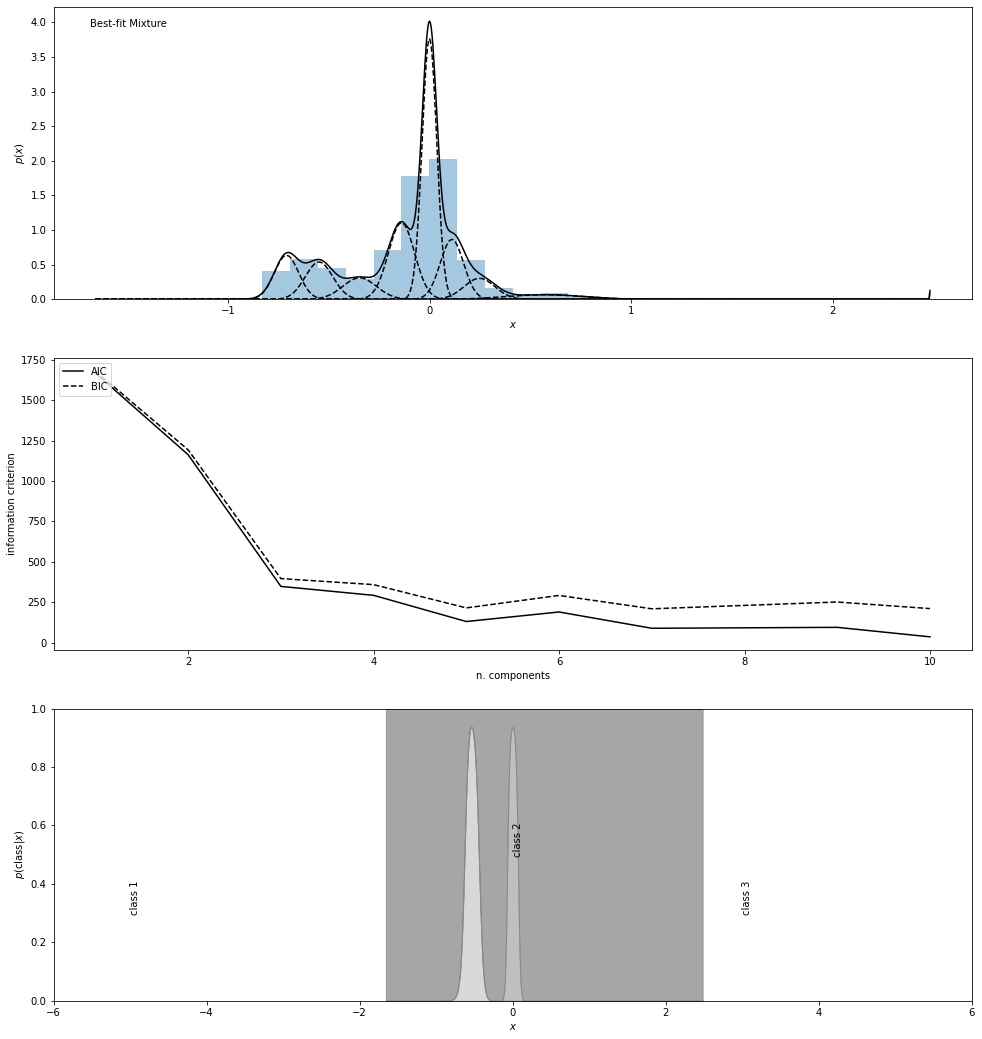

In [34]:

#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

fig = plt.figure(figsize=(15, 20))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(311)
M_best = models[np.argmin(AIC)]

x = np.linspace(X.min(), X.max(), 1000)
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(312)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(313)

p = responsibilities
p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T

ax.fill_between(x, 0, p[0], color='gray', alpha=0.3)
ax.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
ax.fill_between(x, p[1], 1, color='gray', alpha=0.7)
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')

ax.text(-5, 0.3, 'class 1', rotation='vertical')
ax.text(0, 0.5, 'class 2', rotation='vertical')
ax.text(3, 0.3, 'class 3', rotation='vertical')

plt.show()


In [ ]:
print(len(dfa))

In [ ]:
dfa.primitive.unique()

In [ ]:
dfa[dfa['mse'] >= 10]

In [19]:
idx = 83
stroke_idx = 1

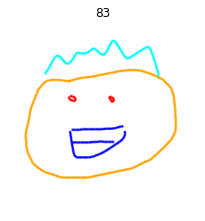

In [20]:
# print(dict(filter(lambda x: x[0][0] == idx, M_name.items())))

rd.show_these_sketches(
    CONST.face_json,
    [idx], 
    [str(idx)], 
    [[]], 
    num_pngs_per_row = 6,
    row_figsize = 4,
    column_figsize = 4,
)



In [19]:
strokes_spline_fitted = rd.process_quickdraw_to_part_convex_hull(
    drawing_arr[idx],
    list(CONST.face_parts_idx_dict.keys()),
    b_spline_num_sampled_points=200,
)

# strokes_spline_fitted = rd.process_quickdraw_to_stroke_no_normalize(
#     drawing_arr[idx], 
#     b_spline_num_sampled_points=200,
# )
# print(len(strokes_spline_fitted))

In [ ]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

parts_indices = list(CONST.face_parts_idx_dict.keys())

drawing_raw = np.asarray(drawing_arr[idx])
drawing_raw[:,0] = np.cumsum(drawing_raw[:,0], 0) + 25
drawing_raw[:,1] = np.cumsum(drawing_raw[:,1], 0) + 25

parts = []
part_idx_part = {}

for k in parts_indices:
    strokes = drawing_raw[drawing_raw[:,-1] == k]
    if len(strokes) < 1:
        continue
    parts.append(strokes)
    part_idx_part[k] = strokes[:,:2]

In [ ]:
np.sum(parts[0][:,2] == 1)

In [ ]:
part = part_idx_part[2]
strokes = part[:,:2]
maxs = np.max(strokes, axis=0)
mins = np.min(strokes, axis=0)
ll = maxs - mins

more_than_3 = len(strokes) >= 3
has_length_x =  not np.isclose(ll[0], 0.0, rtol=1, atol=1e-05)
has_length_y = not np.isclose(ll[1], 0.0, rtol=1, atol=1e-05)

if more_than_3 and has_length_x and has_length_y:
    hull = ConvexHull(strokes)
    hull_vert = strokes[hull.vertices]
else:

    if not has_length_x:
        reg = LinearRegression().fit(strokes[:,1].reshape(-1,1), strokes[:,0])
        test_xs = np.linspace(mins[1], maxs[1], 30)
        test_ys = reg.predict(test_xs.reshape(-1,1))
        test_data  = np.hstack([test_xs.reshape(-1,1), test_ys.reshape(-1,1)])
        mask = np.zeros(len(test_data))
        mask[:10] = 1
        np.random.shuffle(mask)
        #test_data = test_data + (np.random.normal(0, 0.05, len(test_data)) * mask).reshape(-1,1)
        test_data[:,1] = test_data[:,1] + (np.random.normal(0, 0.05, len(test_data)) * mask)
        hull = ConvexHull(test_data)
        hull_vert = np.hstack([
            test_data[hull.vertices][:,1:],
            test_data[hull.vertices][:,:1],
        ])
    else:
        reg = LinearRegression().fit(strokes[:,0].reshape(-1,1), strokes[:,1])
        test_xs = np.linspace(mins[0], maxs[0], 30)
        test_ys = reg.predict(test_xs.reshape(-1,1))
        test_data  = np.hstack([test_xs.reshape(-1,1), test_ys.reshape(-1,1)])
        mask = np.zeros(len(test_data))
        mask[:10] = 1
        np.random.shuffle(mask)
        
        if not has_length_y:
            test_data[:,1] = test_data[:,1] + (np.random.normal(0, 0.05, len(test_data)) * mask)
        else:
            test_data[:,0] = test_data[:,0] + (np.random.normal(0, 0.05, len(test_data)) * mask)
        
        hull = ConvexHull(test_data)
        hull_vert = test_data[hull.vertices]

plt.scatter(strokes[:,0], strokes[:,1], c='g')
# plt.scatter(test_data[:,0], test_data[:,1], c='b', alpha=0.5)
# plt.scatter(test_data[:,1], test_data[:,0], c='b', alpha=0.5)

# hull_vert = np.concatenate([hull_vert, hull_vert[0].reshape(1,-1)])     
plt.plot(hull_vert[:,0], hull_vert[:,1], c='g', alpha=0.3)
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
for i,(part, hull) in enumerate(zip(parts, strokes_spline_fitted)):
#     if i != 1:
#         continue
    plt.plot(part[:,0], part[:,1], c='g')
    #plt.scatter(part[:,0], part[:,1], s=1, c='g')
    #plt.scatter(hull[:,0], hull[:,1], s=1, c='r', alpha=0.6)
# plt.scatter(hulls[0][:,0], hulls[0][:,1])
plt.xlim(0,w)
plt.ylim(h,0)
plt.show()

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for index, entry in dfa[dfa.image == idx].iterrows():
    data = strokes_spline_fitted[entry.stroke]
    
    template_func = TEMPLATE_DICT[entry.primitive]
    template = template_func(n)
    
    print(entry.M.reshape(3,3))
    
    result, mse = rd.get_transformed_template(template, data, entry.M.reshape(3,3),projective=use_projective)
    ax1.scatter(result[:,0], result[:,1], label="transformed template", s=1, c='r')
    ax2.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c='g')
    orig_data = part_idx_part[int(entry.stroke)]
    ax2.plot(orig_data[:,0], orig_data[:,1], alpha=0.5, c='b')
    
#     ax1.plot(result[:,0], result[:,1], label="transformed template", c='r')
#     ax2.plot(data[:,0], data[:,1], label="data", alpha=0.5,c='g')

# plt.legend()
# plt.xlim(0,w)
# plt.ylim(h,0)

ax1.axis(xmin=0,xmax=w)
ax1.axis(ymin=h,ymax=0)

ax2.axis(xmin=0,xmax=w)
ax2.axis(ymin=h,ymax=0)

plt.show()

In [20]:
entry = dfa[dfa.image == idx].iloc[2]
data = strokes_spline_fitted[entry['stroke']]
template_func = TEMPLATE_DICT[entry['primitive']]
template = template_func(n)

print(entry['M'].reshape(3,3))

result, mse = rd.get_transformed_template(template, data, entry['M'].reshape(3,3),projective=use_projective)
print(mse)

[[ 0.6562  0.0192 45.9962]
 [-0.0372 -0.2341 77.7728]
 [ 0.      0.      1.    ]]
30.428401582225533


In [17]:
dfa[dfa.image == idx]

,image,stroke,M,primitive,mse
315,83,0.0,"[-0.12135445774080379, 0.12729385011427752, 11...",square,1.221216
316,83,2.0,"[0.2968504097355662, 0.007759808020350079, 79....",semicircle,9.139419
317,83,4.0,"[0.6561608022209431, 0.01919516397916056, 45.9...",zigzag1,30.428402
318,83,6.0,"[-0.32040842540464826, -0.7209469619935103, 25...",circle,87.828024


In [ ]:
from sklearn.metrics import mean_squared_error


In [34]:
xt = np.asarray([[0.5, 1], [-1, 1], [7, -6]])
dst = np.asarray([[0, 2], [-1, 2], [8, -5]])
d = np.zeros(np.shape(xt))
d[:,0] = xt[:,0]-dst[:,0]
d[:,1] = xt[:,1]-dst[:,1]
r = np.sum(np.square(d[:,0])+np.square(d[:,1]))
r/3

1.4166666666666667

In [36]:
mean_squared_error(xt,dst,multioutput='raw_values')

array([0.4167, 1.    ])

In [38]:
def fit_transformation_loss(T,src,dst):
    
    n = np.size(src,0)
    xt = np.ones([n,3])
    xt[:,:-1] = src
    xt = xt @ T.T
    #xt = xt.T
    d = np.zeros(np.shape(src))
    d[:,0] = xt[:,0]-dst[:,0]
    d[:,1] = xt[:,1]-dst[:,1]
    r = np.sum(np.square(d[:,0])+np.square(d[:,1]))
    return r/n

fit_transformation_loss(entry['M'].reshape(3,3), template, data)

60.85678989881457

In [39]:
entry['M'].reshape(3,3)

array([[ 0.6562,  0.0192, 45.9962],
       [-0.0372, -0.2341, 77.7728],
       [ 0.    ,  0.    ,  1.    ]])

In [ ]:
dfa[dfa.image == idx].M[98].reshape((3,3))

In [ ]:
dfa[dfa.image == idx].M[99].reshape((3,3))

In [11]:
# dfn = new_df_pair()
dfo = pd.read_csv('/raid/xiaoyuz1/amazon_turk/df_all.csv')
dfo['no_punc_1'] = dfo.no_punc_1.apply(lambda x: [str(y).strip()[1:-1] for y in x[1:-1].split(',')])
# dfn = new_df_pair()
dfp = pd.read_csv('/raid/xiaoyuz1/amazon_turk/df_all_pair.csv')
dfp['no_punc_1'] = dfp.no_punc_1.apply(lambda x: [str(y).strip()[1:-1] for y in x[1:-1].split(',')])
dfp['no_punc_2'] = dfp.no_punc_2.apply(lambda x: [str(y).strip()[1:-1] for y in x[1:-1].split(',')])

In [13]:
drawing_arr[722]

[[139.36842105263156, 4.21052631578948, 0, 6],
 [-2.10526315789474, -1.2631578947368496, 0, 6],
 [-2.10526315789474, -0.8421052631578902, 0, 6],
 [-4.21052631578948, -0.8421052631578902, 0, 6],
 [-2.10526315789474, 0.0, 0, 6],
 [-4.210526315789423, -0.8421052631579045, 0, 6],
 [-2.10526315789474, 0.0, 0, 6],
 [-2.10526315789474, -0.4210526315789451, 0, 6],
 [-24.0, 0.0, 0, 6],
 [-2.10526315789474, 0.4210526315789451, 0, 6],
 [-2.10526315789474, 0.0, 0, 6],
 [-2.10526315789474, 0.4210526315789451, 0, 6],
 [-2.10526315789474, 0.0, 0, 6],
 [-6.736842105263179, 1.2631578947368496, 0, 6],
 [-2.10526315789474, 0.8421052631578902, 0, 6],
 [-4.21052631578948, 0.8421052631579045, 0, 6],
 [-6.315789473684163, 2.526315789473685, 0, 6],
 [-2.10526315789474, 0.4210526315789451, 0, 6],
 [-2.10526315789474, 0.8421052631578902, 0, 6],
 [-2.10526315789474, 1.2631578947368354, 0, 6],
 [-2.10526315789474, 0.8421052631579045, 0, 6],
 [-14.736842105263179, 8.84210526315789, 0, 6],
 [-6.3157894736842195, 5.

In [12]:
dfo

,image_1,worker_id,part,category,time,folder,text_1,tokenized_1,lower_1,no_punc_1,no_punc_str_1
0,722,AKQAI78JTXXC9,0,face,353.0,/raid/xiaoyuz1/amazon_turk/2022_03_21_release,linear,['linear'],['linear'],[linear],linear
1,260,AKQAI78JTXXC9,0,face,353.0,/raid/xiaoyuz1/amazon_turk/2022_03_21_release,open oval,"['open', 'oval']","['open', 'oval']","[open, oval]",open oval
2,556,AKQAI78JTXXC9,1,face,353.0,/raid/xiaoyuz1/amazon_turk/2022_03_21_release,small curved,"['small', 'curved']","['small', 'curved']","[small, curved]",small curved
3,144,AKQAI78JTXXC9,1,face,353.0,/raid/xiaoyuz1/amazon_turk/2022_03_21_release,large curved,"['large', 'curved']","['large', 'curved']","[large, curved]",large curved
4,419,AKQAI78JTXXC9,2,face,353.0,/raid/xiaoyuz1/amazon_turk/2022_03_21_release,wide u-shaped,"['wide', 'u', '-']","['wide', 'u', '-']","[wide, u]",wide u
...,...,...,...,...,...,...,...,...,...,...,...
11145,280,APGX2WZ59OWDN,5,angel,239.0,/raid/xiaoyuz1/amazon_turk/2022_04_06_release_3,serrated,['serrate'],['serrate'],[serrate],serrate
11146,736,APGX2WZ59OWDN,7,angel,239.0,/raid/xiaoyuz1/amazon_turk/2022_04_06_release_3,butterfly-shaped,"['butterfly', '-']","['butterfly', '-']",[butterfly],butterfly
11147,477,APGX2WZ59OWDN,7,angel,239.0,/raid/xiaoyuz1/amazon_turk/2022_04_06_release_3,bumpy,['bumpy'],['bumpy'],[bumpy],bumpy
11148,614,APGX2WZ59OWDN,4,angel,239.0,/raid/xiaoyuz1/amazon_turk/2022_04_06_release_3,rectangular,['rectangular'],['rectangular'],[rectangular],rectangular


In [ ]:
dfo[(dfo['image_1'] == idx)]

In [ ]:
reload(rd)
M_arr_idx, M_name_idx, M_mse_idx = {},{},{}

template_dict = {
    #'arc' : lambda n : rd.generate_arc(n1=n),
    'circle' : lambda n : rd.generate_circle(n1=n, radius=100, x0=100, y0=100, template_size=256),
    'square' : lambda n : rd.generate_square(n1=n, template_size=256),
    'semicircle' : lambda n : rd.generate_semicircle(n1=n, radius=100, x0=100, y0=100, template_size=256),
    'zigzag3' : lambda n : rd.generate_zigzag3(n1=n, template_size=256),
    #'zigzag1' : lambda n : rd.generate_zigzag1(n1=n, template_size=256),
    'zigzag5' : lambda n : rd.generate_zigzag(n1=n,num_fold=5, template_size=256),
    'zigzag7' : lambda n : rd.generate_zigzag(n1=n,num_fold=7, template_size=256),
    'zigzag10' : lambda n : rd.generate_zigzag(n1=n,num_fold=10, template_size=256),
}


for stroke_index, data in enumerate(strokes_spline_fitted):
    mat, prim_name, prim_mse = rd.get_transform_smallest_mse(data, template_dict, \
                                                            n=200, use_projective=True)
    M_arr_idx[(idx, stroke_index)] = mat
    M_name_idx[(idx, stroke_index)] = prim_name
    M_mse_idx[(idx, stroke_index)] = prim_mse

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for k, M in M_arr_idx.items():
    if k[1] != 3:
        continue
    data = strokes_spline_fitted[k[1]]
    template_func = template_dict[M_name_idx[k]]
    template = template_func(n)
    
    result, mse = rd.get_transformed_template(template, data, M.reshape(3,3),projective=True)
    ax1.scatter(result[:,0], result[:,1], label="transformed template", s=1, c='r')
    ax1.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c='g')

# plt.legend()
# plt.xlim(0,w)
# plt.ylim(h,0)

# ax1.axis(xmin=0,xmax=w)
# ax1.axis(ymin=h,ymax=0)

# ax2.axis(xmin=0,xmax=w)
# ax2.axis(ymin=h,ymax=0)

plt.show()

In [ ]:
data = strokes_spline_fitted[stroke_idx]

In [ ]:
data = strokes_spline_fitted[stroke_idx]
template_func = rd.TEMPLATE_DICT[M_name[(idx, stroke_idx)]]
template = template_func(n)

result, mse = rd.get_transformed_template(template, data, M_arr[(idx, stroke_idx)].reshape(3,3))

print(mse)

datacolors = rd.get_sequence_colors(n, plt.cm.Greens)
templatecolors = rd.get_sequence_colors(n, plt.cm.Reds)

plt.figure(figsize=(6, 6))
# plt.scatter(result[:,0], result[:,1], label="transformed template", s=1, \
#             c=templatecolors)
# plt.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c=datacolors)

plt.scatter(result[:,0], result[:,1], label="transformed template", s=1, c='r')
plt.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c='g')

plt.legend()
# plt.xlim(0,w)
# plt.ylim(h,0)

plt.show()

In [ ]:
reload(rd)

In [ ]:
data = strokes_spline_fitted[stroke_idx]

In [ ]:

print(M_name[(idx, stroke_idx)])

template_func = rd.TEMPLATE_DICT[M_name[(idx, stroke_idx)]]

In [ ]:
projectiveM = M_arr[(idx, stroke_idx)]
template = template_func(n)
src_pts = template.astype(np.float32).reshape(-1,1,2)
result = cv2.perspectiveTransform(src_pts, projectiveM.reshape(3,3)).reshape(-1,2)

In [ ]:
# calculate ourselves
template_func = rd.TEMPLATE_DICT['zigzag1']
template = template_func(n)

# template = rd.generate_zigzag(num_fold=10)
M, result = rd.get_transform(template, data, projective=True)

In [ ]:
data.shape, template.shape

In [ ]:
mse = mean_squared_error(result, data)
print(mse)

datacolors = rd.get_sequence_colors(n, plt.cm.Greens)
templatecolors = rd.get_sequence_colors(n, plt.cm.Reds)

plt.figure(figsize=(6, 6))
# plt.scatter(result[:,0], result[:,1], label="transformed template", s=1, \
#             c=templatecolors)
# plt.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c=datacolors)

plt.scatter(result[:,0], result[:,1], label="transformed template", s=1, c='r')
plt.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c='g')

plt.legend()
# plt.xlim(0,w)
# plt.ylim(h,0)

plt.show()

In [ ]:
import cv2
import numpy as np
import sys
from numpy.random import *

In [ ]:
def del_miss(indeces, dist, max_dist, th_rate = 0.8):
    th_dist = max_dist * th_rate
    return np.array([indeces[0][np.where(dist.T[0] < th_dist)]])


In [ ]:
def is_converge(Tr, scale):
    delta_angle = 0.0001
    delta_scale = scale * 0.0001
    
    min_cos = 1 - delta_angle
    max_cos = 1 + delta_angle
    min_sin = -delta_angle
    max_sin = delta_angle
    min_move = -delta_scale
    max_move = delta_scale
    
    return min_cos < Tr[0, 0] and Tr[0, 0] < max_cos and \
           min_cos < Tr[1, 1] and Tr[1, 1] < max_cos and \
           min_sin < -Tr[1, 0] and -Tr[1, 0] < max_sin and \
           min_sin < Tr[0, 1] and Tr[0, 1] < max_sin and \
           min_move < Tr[0, 2] and Tr[0, 2] < max_move and \
           min_move < Tr[1, 2] and Tr[1, 2] < max_move

In [ ]:
def icp(d1, d2, max_iterate = 100):
    src = np.array([d1.T], copy=True).astype(np.float32)
    dst = np.array([d2.T], copy=True).astype(np.float32)
    
    knn = cv2.KNearest()
    responses = np.array(range(len(d2[0]))).astype(np.float32)
    knn.train(src[0], responses)
        
    Tr = np.array([[np.cos(0), -np.sin(0), 0],
                   [np.sin(0), np.cos(0),  0],
                   [0,         0,          1]])

    dst = cv2.transform(dst, Tr[0:2])
    max_dist = sys.maxint
    
    scale_x = np.max(d1[0]) - np.min(d1[0])
    scale_y = np.max(d1[1]) - np.min(d1[1])
    scale = max(scale_x, scale_y)
       
    for i in range(max_iterate):
        ret, results, neighbours, dist = knn.find_nearest(dst[0], 1)
        
        indeces = results.astype(np.int32).T     
        indeces = del_miss(indeces, dist, max_dist)  
        
        T = cv2.estimateRigidTransform(dst[0, indeces], src[0, indeces], True)

        max_dist = np.max(dist)
        dst = cv2.transform(dst, T)
        Tr = np.dot(np.vstack((T,[0,0,1])), Tr)
        
        if (is_converge(T, scale)):
            break
        
    return Tr[0:2]

In [ ]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    point_count = 100
    th = np.pi / 8
    move = np.array([[0.30], [0.5]])
    rnd_scale = 0.03
    x1 = np.linspace(0, 1.1, point_count)
    y1 = np.sin(x1 * np.pi)
    d1 = np.array([x1, y1])

    rot = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
    rand = np.random.rand(2, point_count)*rnd_scale
    d2 = np.dot(rot, d1) + move
    d2 = np.add(d2, rand)

    plt.plot(d1[0], d1[1])
    plt.plot(d2[0], d2[1])
    plt.show()

In [ ]:
    ret = icp(d1, d2)
    
    plt.plot(d1[0], d1[1])
    dst = np.array([d2.T], copy=True).astype(np.float32)
    dst = cv2.transform(dst, ret)
    plt.plot(dst[0].T[0], dst[0].T[1])
    plt.show()
    
    print ret[0][0] * ret[0][0] + ret[0][1] * ret[0][1]
    print np.arccos(ret[0][0]) / 2 / np.pi * 360
    print np.arcsin(ret[0][1]) / 2 / np.pi * 360

    print ret

In [ ]:
def icp(a, b,
        max_time = 1
    ):
    import cv2
    import numpy
    import copy
    import pylab
    import time
    import sys
    import sklearn.neighbors
    import scipy.optimize



    def res(p,src,dst):
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        r = numpy.sum(numpy.square(d[:,0])+numpy.square(d[:,1]))
        return r

    def jac(p,src,dst):
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = numpy.matrix([[-numpy.sin(p[2]),-numpy.cos(p[2])],
                            [ numpy.cos(p[2]),-numpy.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        g = numpy.array([  numpy.sum(2*d[:,0]),
                        numpy.sum(2*d[:,1]),
                        numpy.sum(2*(d[:,0]*dUdth[:,0]+d[:,1]*dUdth[:,1])) ])
        return g
    
    def hess(p,src,dst):
        n = numpy.size(src,0)
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = numpy.matrix([[-numpy.sin(p[2]),-numpy.cos(p[2])],[numpy.cos(p[2]),-numpy.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        H = numpy.zeros([3,3])
        H[0,0] = n*2
        H[0,2] = numpy.sum(2*dUdth[:,0])
        H[1,1] = n*2
        H[1,2] = numpy.sum(2*dUdth[:,1])
        H[2,0] = H[0,2]
        H[2,1] = H[1,2]
        d2Ud2th_R = numpy.matrix([[-numpy.cos(p[2]), numpy.sin(p[2])],[-numpy.sin(p[2]),-numpy.cos(p[2])]])
        d2Ud2th = (src*d2Ud2th_R.T).A
        H[2,2] = numpy.sum(2*(numpy.square(dUdth[:,0])+numpy.square(dUdth[:,1]) + d[:,0]*d2Ud2th[:,0]+d[:,0]*d2Ud2th[:,0]))
        return H
    
    
    t0 = time.time()
    init_pose = (0,0,0)
    src = numpy.array([a.T], copy=True).astype(numpy.float32)
    dst = numpy.array([b.T], copy=True).astype(numpy.float32)
    Tr = numpy.array([[numpy.cos(init_pose[2]),-numpy.sin(init_pose[2]),init_pose[0]],
                   [numpy.sin(init_pose[2]), numpy.cos(init_pose[2]),init_pose[1]],
                   [0,                    0,                   1          ]])
    print("src",numpy.shape(src))
    print("Tr[0:2]",numpy.shape(Tr[0:2]))
    src = cv2.transform(src, Tr[0:2])
    p_opt = numpy.array(init_pose)
    T_opt = numpy.array([])
    error_max = sys.maxsize
    first = False
    while not(first and time.time() - t0 > max_time):
        distances, indices = sklearn.neighbors.NearestNeighbors(n_neighbors=1, algorithm='auto',p = 3).fit(dst[0]).kneighbors(src[0])
        p = scipy.optimize.minimize(res,[0,0,0],args=(src[0],dst[0, indices.T][0]),method='Newton-CG',jac=jac,hess=hess).x
        T  = numpy.array([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],[numpy.sin(p[2]), numpy.cos(p[2]),p[1]]])
        p_opt[:2]  = (p_opt[:2]*numpy.matrix(T[:2,:2]).T).A       
        p_opt[0] += p[0]
        p_opt[1] += p[1]
        p_opt[2] += p[2]
        src = cv2.transform(src, T)
        Tr = (numpy.matrix(numpy.vstack((T,[0,0,1])))*numpy.matrix(Tr)).A
        error = res([0,0,0],src[0],dst[0, indices.T][0])

        if error < error_max:
            error_max = error
            first = True
            T_opt = Tr

    p_opt[2] = p_opt[2] % (2*numpy.pi)
    return T_opt, error_max


def main():
    import cv2
    import numpy
    import random
    import matplotlib.pyplot
    n1 = 100
    n2 = 75
    bruit = 1/10
    center = [random.random()*(2-1)*3,random.random()*(2-1)*3]
    radius = random.random()
    deformation = 2

    template = numpy.array([
        [numpy.cos(i*2*numpy.pi/n1)*radius*deformation for i in range(n1)], 
        [numpy.sin(i*2*numpy.pi/n1)*radius for i in range(n1)]
    ])

    data = numpy.array([
        [numpy.cos(i*2*numpy.pi/n2)*radius*(1+random.random()*bruit)+center[0] for i in range(n2)], 
        [numpy.sin(i*2*numpy.pi/n2)*radius*deformation*(1+random.random()*bruit)+center[1] for i in range(n2)]
    ])

    T,error = icp(data,template)
    dx = T[0,2]
    dy = T[1,2]
    rotation = numpy.arcsin(T[0,1]) * 360 / 2 / numpy.pi

    print("T",T)
    print("error",error)
    print("rotation°",rotation)
    print("dx",dx)
    print("dy",dy)

    result = cv2.transform(numpy.array([data.T], copy=True).astype(numpy.float32), T).T
    matplotlib.pyplot.plot(template[0], template[1], label="template")
    matplotlib.pyplot.plot(data[0], data[1], label="data")
    matplotlib.pyplot.plot(result[0], result[1], label="result: "+str(rotation)+"° - "+str([dx,dy]))
    matplotlib.pyplot.legend(loc="upper left")
    matplotlib.pyplot.axis('square')
    matplotlib.pyplot.show()

if __name__ == "__main__":
    main()